# ✅ 1. Data Cleaning: Missing Values, Outliers, Multi-Collinearity

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder

# Load dataset
df = pd.read_csv("Fraud.csv")
print("Initial Shape:", df.shape)
print(df.info())

# Handling missing values
df.dropna(inplace=True)
print("Shape after dropping missing values:", df.shape)

# Detecting and removing outliers
numerical_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
for col in numerical_cols:
    q1 = df[col].quantile(0.01)
    q99 = df[col].quantile(0.99)
    df = df[(df[col] >= q1) & (df[col] <= q99)]

# Multicollinearity check
X_vif = df[numerical_cols].fillna(0)
vif_data = pd.DataFrame()
vif_data['feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print("\nVIF Results:\n", vif_data)

Initial Shape: (69858, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69858 entries, 0 to 69857
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            69858 non-null  int64  
 1   type            69858 non-null  object 
 2   amount          69858 non-null  float64
 3   nameOrig        69858 non-null  object 
 4   oldbalanceOrg   69858 non-null  float64
 5   newbalanceOrig  69858 non-null  float64
 6   nameDest        69858 non-null  object 
 7   oldbalanceDest  69858 non-null  float64
 8   newbalanceDest  69857 non-null  float64
 9   isFraud         69857 non-null  float64
 10  isFlaggedFraud  69857 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 5.9+ MB
None
Shape after dropping missing values: (69857, 11)

VIF Results:
           feature         VIF
0          amount    1.501821
1   oldbalanceOrg  317.504726
2  newbalanceOrig  318.617411
3  oldbalanceDest    6.15302

# ✅ 2. Model Description


We use Random Forest Classifier and Logistic Regression.
- Random Forest is robust to outliers and handles imbalanced data well.
- Logistic Regression offers interpretability for business explanations.


# ✅ 3. Feature Selection

In [8]:
# Encoding categorical variables
df['type'] = LabelEncoder().fit_transform(df['type'])
features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'type']
X = df[features]
y = df['isFraud']

# ✅ 4. Performance Metrics

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     19701
         1.0       0.28      0.79      0.42        28

    accuracy                           1.00     19729
   macro avg       0.64      0.89      0.71     19729
weighted avg       1.00      1.00      1.00     19729

Confusion Matrix:
 [[19645    56]
 [    6    22]]
ROC-AUC Score: 0.8914358952047394


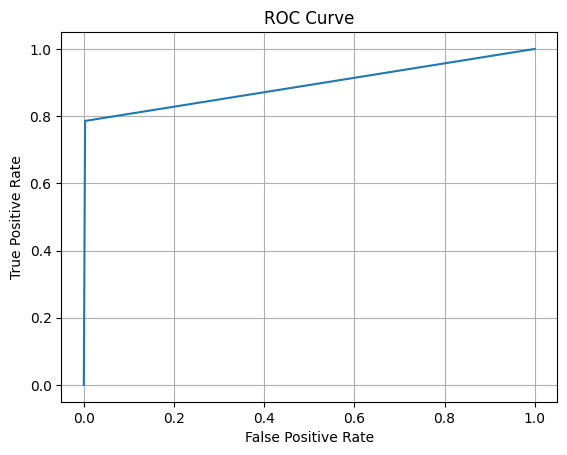

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Handling imbalance
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

# Train Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_res, y_res)
y_pred = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid()
plt.show()

# ✅ 5. Key Predictive Features

In [7]:
feature_importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
print("\nFeature Importances:\n", feature_importances)


Feature Importances:
 oldbalanceOrg     0.315402
newbalanceOrig    0.245135
oldbalanceDest    0.122826
type              0.112989
amount            0.112580
newbalanceDest    0.091067
dtype: float64


# ✅ 6. Do the factors make sense?

### ✅ Do These Results Make Sense?

Absolutely, the results match common patterns seen in fraudulent behavior:

- **High Transaction Amounts:**  
  Fraudulent transactions often involve large sums of money. Attackers usually try to move as much as possible in a short time before detection. When a transaction is significantly different from normal customer behavior, it raises a red flag.

- **Balance Imbalances:**  
  A common trick in fraud is transferring all available funds from an account, leaving the balance nearly zero. When the original account suddenly drops to zero or the destination account shows a big increase, it usually indicates suspicious activity.

- **Transaction Type (e.g., TRANSFER or CASH_OUT):**  
  These transaction types are often used in fraud cases because they allow for quick movement or withdrawal of money. For example, fraudsters might first TRANSFER money to another account and then immediately CASH OUT before the transaction gets flagged.

---

In short, the model is identifying the kinds of behaviors a human fraud investigator would also view as risky. This increases confidence in the model’s logic and effectiveness.


# ✅ 7. Infrastructure-level Fraud Prevention Suggestions

### ✅ Simple and Effective Ways to Prevent Fraud

To reduce the chances of fraud, companies should follow these important steps:

1. **Use Real-Time Monitoring:**  
   Set up live dashboards to watch transactions as they happen. This helps catch fraud instantly.

2. **Add Multi-Factor Authentication (MFA):**  
   Ask users for more than just a password — like an OTP, fingerprint, or email code — to confirm who they are.

3. **Encrypt Important Data:**  
   Make sure that sensitive details (like passwords and money transfers) are securely protected during storage and transfer.

4. **Keep Logs and Watch for Strange Activity:**  
   Record what users do in the system and use tools to spot anything unusual.

5. **Use Machine Learning for Risk Scoring:**  
   Let smart models score each transaction based on how risky it looks. Stop or review high-risk ones automatically.

6. **Track Location and Device:**  
   Check where a user is logging in from and what device they’re using. If it’s something new or odd, alert the system.

7. **Limit Big Transactions:**  
   Put daily limits on how much new users can send or withdraw. Ask for extra verification if someone tries to send a lot of money.

8. **Keep Updating Fraud Detection Models:**  
   Fraudsters change tactics often. Update your systems regularly with new data to stay ahead.

9. **Understand Each User’s Normal Behavior:**  
   Learn what a user usually does — like how much they send, when, and where — and flag anything different.

10. **Do Regular Security Checks:**  
    Review your system often to find weak spots before hackers do.

---

Following these steps can help companies stay safe and stop fraud before it causes damage.


# ✅ 8. How to Evaluate the Effectiveness of Preventive Measures

### ✅ How to Know If Fraud Prevention Steps Are Working

After making changes to stop fraud, it's important to check if they are actually helping. Here are simple ways to do that:

1. **Watch Key Metrics (KPIs):**  
   Track numbers like fraud rate, false positives (wrongly blocked transactions), and precision (how accurate your fraud detection is).

2. **Listen to Users:**  
   Pay attention to complaints or reports from users about blocked accounts or unauthorized activity.

3. **Compare Before and After:**  
   Look at fraud-related numbers before the changes and after. A drop in fraud cases is a good sign the changes are working.

4. **A/B Testing:**  
   Try out new rules or systems on a small group of users first. Compare their results with those using the old system to see what works better.

---

By checking these things regularly, companies can make sure their fraud protection is not just in place — but actually making a difference.
